# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [99]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [100]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [101]:
def show_average_images(train_loader, test_loader, dataset, labels):
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


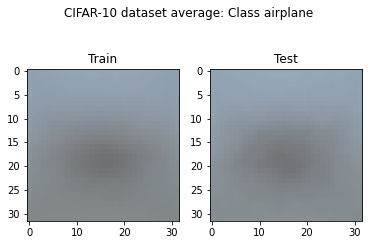

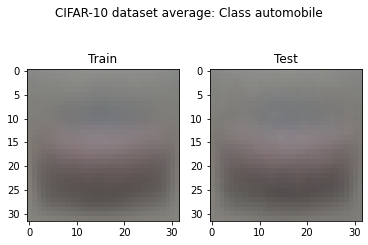

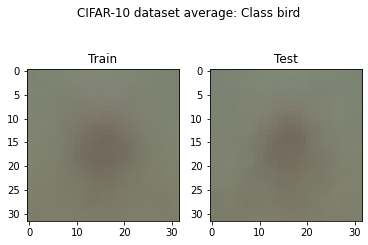

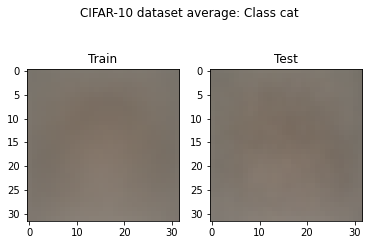

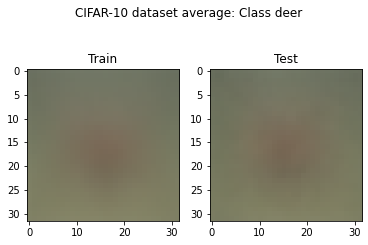

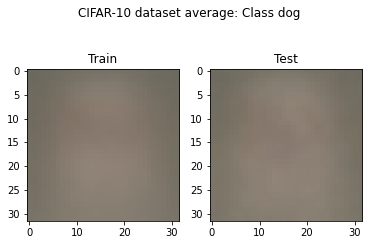

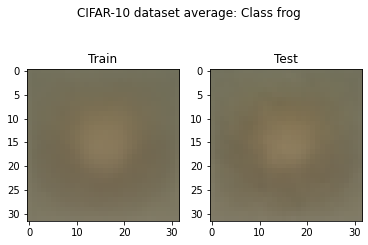

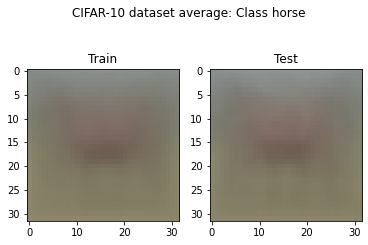

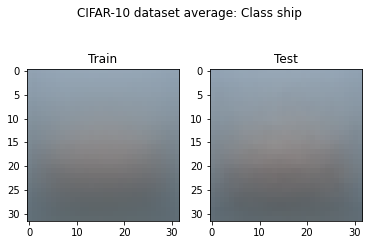

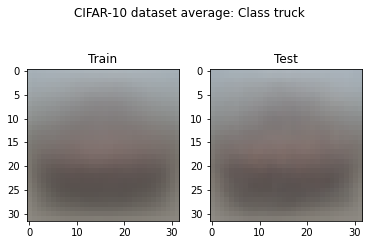

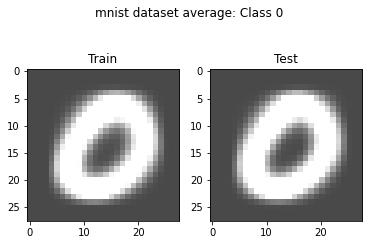

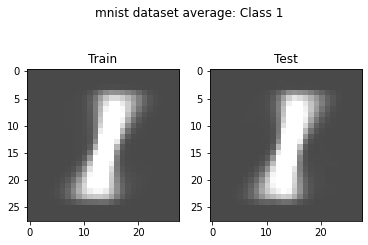

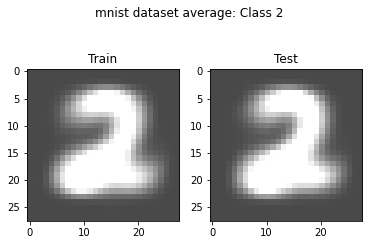

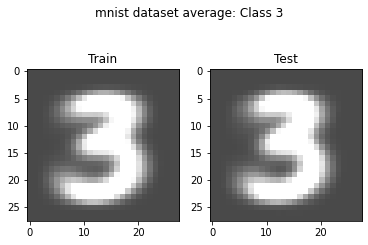

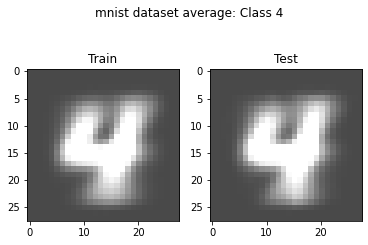

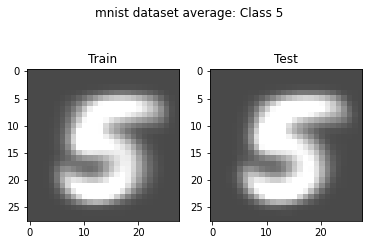

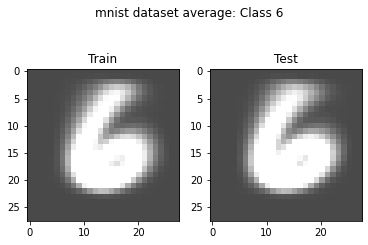

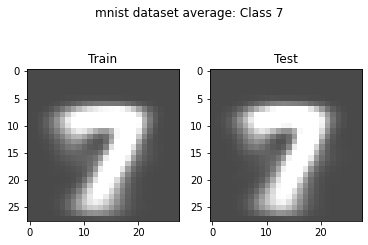

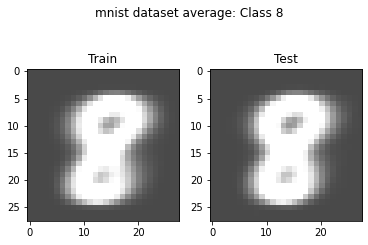

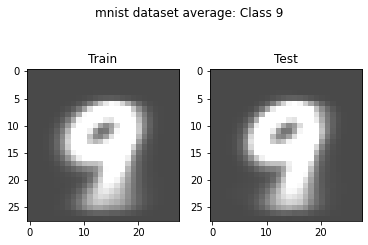

In [102]:
torch.utils.data.DataLoader.num_worker = 0

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [103]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [104]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [105]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss_curve

In [106]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.747064
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.051698
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.924570
Train Epoch: 1 [300/60000 (0%)]	Loss: 6.717960
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.003003
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.003378
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.000007
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.000103
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.096676
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.000007
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.139671
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.000988
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.001402
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.020225
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.293571
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000462
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.236723
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.000001
Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.164266
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000000
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.038642
Trai

Train Epoch: 1 [16800/60000 (28%)]	Loss: 0.000003
Train Epoch: 1 [16900/60000 (28%)]	Loss: 0.000009
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [17100/60000 (28%)]	Loss: 5.478339
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.000744
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.011770
Train Epoch: 1 [17400/60000 (29%)]	Loss: 18.446156
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.000008
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17700/60000 (30%)]	Loss: 13.845102
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.196562
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.000111
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18200/60000 (30%)]	Loss: 4.632814
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.021428
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18500/60000 (31%)]	Loss: 1.414198
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000001
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.00173

Train Epoch: 1 [33600/60000 (56%)]	Loss: 0.005246
Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.000009
Train Epoch: 1 [33800/60000 (56%)]	Loss: 0.000593
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.000383
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.028245
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.389132
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.000049
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.103557
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.015680
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000093
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000078
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000169
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000001
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000196
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000000
Train Epoch: 1 [35300/60000 (59%)]	Loss: 2.085832
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.000008
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.000000


Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.000013
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.000944
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.206889
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.000021
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.000001
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.000001
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000015
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.003928
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000012
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.000088
Train Epoch: 1 [51600/60000 (86%)]	Loss: 6.537537
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.000000
Train Epoch: 1 [52100/60000 (87%)]	Loss: 0.000061


Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.000719
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.012728
Train Epoch: 2 [7600/60000 (13%)]	Loss: 6.272547
Train Epoch: 2 [7700/60000 (13%)]	Loss: 1.529086
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.040758
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.066194
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000011
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000033
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8500/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.116202
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.000007
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.636346
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.000067
Train Epoch: 2 [9100/60000 (15%)]	Loss: 0.000002
Train Epoch: 2 [9200/60000 (15%)]	Loss: 0.000001
Train Epoch: 2 [9300/60000 (16%)]	Loss: 0.001876
Train Epoch: 2 [9400

Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24400/60000 (41%)]	Loss: 9.732584
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.015067
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.007923
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.033476
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000034
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.167697
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.105376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.082756
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.000042
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.000039
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.008706
Train Epoch: 2 [26000/60000 (43%)]	Loss: 2.525035
Train Epoch: 2 [26100/60000 (44%)]	Loss: 0.000000
Train Epoch: 2 [26200/60000 (44%)]	Loss: 0.257740


Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000003
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000149
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.000001
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.039840
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.000003
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.378751
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.001028
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.000002
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.030329
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000005
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.002919
Train Epoch: 2 [42100/60000 (70%)]	Loss: 0.445229
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.000563
Train Epoch: 2 [42300/60000 (70%)]	Loss: 0.000080
Train Epoch: 2 [42400/60000 (71%)]	Loss: 8.717375
Train Epoch: 2 [42500/60000 (71%)]	Loss: 2.187980
Train Epoch: 2 [42600/60000 (71%)]	Loss: 0.000003
Train Epoch: 2 [42700/60000 (71%)]	Loss: 0.000110
Train Epoch: 2 [42800/60000 (71%)]	Loss: 0.000002


Train Epoch: 2 [57500/60000 (96%)]	Loss: 0.000014
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000003
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000529
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [58000/60000 (97%)]	Loss: 20.992466
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000360
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000006
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.409836
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000002
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.046722
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.000677
Train Epoch: 2 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58900/60000 (98%)]	Loss: 0.000551
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [59100/60000 (98%)]	Loss: 0.112836
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.000006
Train Epoch: 2 [59300/60000 (99%)]	Loss: 0.000039
Train Epoch: 2 [59400/60000 (99%)]	Loss: 3.569709

Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.000041
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.022690
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.008004
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000003
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.006378
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.001957
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.148843
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.003081
Train Epoch: 3 [15900/60000 (26%)]	Loss: 8.022024
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.000006
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.000682
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000001
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.220338
Train Epoch: 3 [16400/60000 (27%)]	Loss: 0.000013
Train Epoch: 3 [16500/60000 (28%)]	Loss: 0.000020
Train Epoch: 3 [16600/60000 (28%)]	Loss: 0.001107


Train Epoch: 3 [31300/60000 (52%)]	Loss: 6.239596
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31500/60000 (52%)]	Loss: 1.576108
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000001
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.027313
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.001523
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.000105
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32600/60000 (54%)]	Loss: 1.745700
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.000007
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.000000
Train Epoch: 3 [32900/60000 (55%)]	Loss: 0.000000
Train Epoch: 3 [33000/60000 (55%)]	Loss: 0.021871
Train Epoch: 3 [33100/60000 (55%)]	Loss: 0.000001
Train Epoch: 3 [33200/60000 (55%)]	Loss: 0.000000


Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.080505
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.000122
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48400/60000 (81%)]	Loss: 13.403822
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.007615
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.160224
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.157874
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000090
Train Epoch: 3 [48900/60000 (82%)]	Loss: 1.600389
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000020
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000067
Train Epoch: 3 [49300/60000 (82%)]	Loss: 0.024582
Train Epoch: 3 [49400/60000 (82%)]	Loss: 0.011456
Train Epoch: 3 [49500/60000 (82%)]	Loss: 0.000312
Train Epoch: 3 [49600/60000 (83%)]	Loss: 9.577964
Train Epoch: 3 [49700/60000 (83%)]	Loss: 0.001276
Train Epoch: 3 [49800/60000 (83%)]	Loss: 0.000000
Train Epoch: 3 [49900/60000 (83%)]	Loss: 0.000001
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.000000

Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000366
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.000540
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.000012
Train Epoch: 4 [5600/60000 (9%)]	Loss: 13.762796
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.000021
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.007319
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6100/60000 (10%)]	Loss: 0.003240
Train Epoch: 4 [6200/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6300/60000 (10%)]	Loss: 0.000004
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6500/60000 (11%)]	Loss: 0.433730
Train Epoch: 4 [6600/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6700/60000 (11%)]	Loss: 0.000031
Train Epoch: 4 [6800/60000 (11%)]	Loss: 0.000843
Train Epoch: 4 [6900/60000 (12%)]	Loss: 0.000001
Train Epoch: 4 [7000/60000 (12%)]	Loss: 0.006381
Train Epoch: 4 [7100/60000 (12%)]	Loss: 13.121853
Train Epoch: 4 [7200/60

Train Epoch: 4 [21900/60000 (36%)]	Loss: 4.494335
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000053
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.016405
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.154639
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000002
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000031
Train Epoch: 4 [22800/60000 (38%)]	Loss: 0.000022
Train Epoch: 4 [22900/60000 (38%)]	Loss: 4.847804
Train Epoch: 4 [23000/60000 (38%)]	Loss: 0.038973
Train Epoch: 4 [23100/60000 (38%)]	Loss: 0.000001
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.061233
Train Epoch: 4 [23300/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23400/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23500/60000 (39%)]	Loss: 0.000900
Train Epoch: 4 [23600/60000 (39%)]	Loss: 0.000030
Train Epoch: 4 [23700/60000 (40%)]	Loss: 0.000046
Train Epoch: 4 [23800/60000 (40%)]	Loss: 0.017456


Train Epoch: 4 [38500/60000 (64%)]	Loss: 0.014944
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.179513
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000008
Train Epoch: 4 [38800/60000 (65%)]	Loss: 0.000016
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.208212
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39100/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.000945
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.000003
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.000001
Train Epoch: 4 [39800/60000 (66%)]	Loss: 0.000003
Train Epoch: 4 [39900/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.007897
Train Epoch: 4 [40100/60000 (67%)]	Loss: 9.670075
Train Epoch: 4 [40200/60000 (67%)]	Loss: 0.000018
Train Epoch: 4 [40300/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40400/60000 (67%)]	Loss: 0.000001


Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.000001
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55600/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56100/60000 (94%)]	Loss: 14.394025
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.001801
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.001876
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.001437
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56600/60000 (94%)]	Loss: 0.170643
Train Epoch: 4 [56700/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56800/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [56900/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [57000/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [57100/60000 (95%)]	Loss: 4.612568
Train Epoch: 4 [57200/60000 (95%)]	Loss: 0.000004
Train Epoch: 4 [57300/60000 (96%)]	Loss: 0.000000

Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.106208
Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.000007
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.000007
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000012
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000015
Train Epoch: 5 [13100/60000 (22%)]	Loss: 2.629185
Train Epoch: 5 [13200/60000 (22%)]	Loss: 4.769093
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.339935
Train Epoch: 5 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13600/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [13700/60000 (23%)]	Loss: 0.000001
Train Epoch: 5 [13800/60000 (23%)]	Loss: 0.006910
Train Epoch: 5 [13900/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.003809
Train Epoch: 5 [14100/60000 (24%)]	Loss: 0.000001
Train Epoch: 5 [14200/60000 (24%)]	Loss: 0.000001


Train Epoch: 5 [29100/60000 (48%)]	Loss: 0.000007
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.000128
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.878672
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.214774
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.678868
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.414939
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.000450
Train Epoch: 5 [30100/60000 (50%)]	Loss: 5.308928
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.000076
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.000921
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.001505
Train Epoch: 5 [30500/60000 (51%)]	Loss: 5.802760
Train Epoch: 5 [30600/60000 (51%)]	Loss: 0.015325
Train Epoch: 5 [30700/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30800/60000 (51%)]	Loss: 0.036300
Train Epoch: 5 [30900/60000 (52%)]	Loss: 0.000006
Train Epoch: 5 [31000/60000 (52%)]	Loss: 0.000168


Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.001111
Train Epoch: 5 [45800/60000 (76%)]	Loss: 0.000001
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.006796
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.014637
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.378762
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.095081
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000003
Train Epoch: 5 [46700/60000 (78%)]	Loss: 0.001800
Train Epoch: 5 [46800/60000 (78%)]	Loss: 3.989780
Train Epoch: 5 [46900/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000011
Train Epoch: 5 [47100/60000 (78%)]	Loss: 0.000152
Train Epoch: 5 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47300/60000 (79%)]	Loss: 0.013168
Train Epoch: 5 [47400/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47500/60000 (79%)]	Loss: 1.719457


Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000614
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000010
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3100/60000 (5%)]	Loss: 0.603185
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.000055
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.655098
Train Epoch: 6 [3500/60000 (6%)]	Loss: 0.013254
Train Epoch: 6 [3600/60000 (6%)]	Loss: 27.253799
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.000005
Train Epoch: 6 [3800/60000 (6%)]	Loss: 3.001343
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4100/60000 (7%)]	Loss: 0.006665
Train Epoch: 6 [4200/60000 (7%)]	Loss: 0.015185
Train Epoch: 6 [4300/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4400/60000 (7%)]	Loss: 

Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.688860
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.008080
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.251813
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.079252
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.000007
Train Epoch: 6 [20200/60000 (34%)]	Loss: 1.792336
Train Epoch: 6 [20300/60000 (34%)]	Loss: 10.670124
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20700/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.000623
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [21000/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [21100/60000 (35%)]	Loss: 0.000001
Train Epoch: 6 [21200/60000 (35%)]	Loss: 0.000080
Train Epoch: 6 [21300/60000 (36%)]	Loss: 1.616986

Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000010
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36300/60000 (60%)]	Loss: 5.993911
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36700/60000 (61%)]	Loss: 0.000095
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000010
Train Epoch: 6 [36900/60000 (62%)]	Loss: 0.000570
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37100/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37200/60000 (62%)]	Loss: 0.021375
Train Epoch: 6 [37300/60000 (62%)]	Loss: 4.770285
Train Epoch: 6 [37400/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37500/60000 (62%)]	Loss: 0.000002
Train Epoch: 6 [37600/60000 (63%)]	Loss: 0.000172
Train Epoch: 6 [37700/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [37800/60000 (63%)]	Loss: 10.375113
Train Epoch: 6 [37900/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [38000/60000 (63%)]	Loss: 7.784636

Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000064
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.007637
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.079319
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53300/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.000809
Train Epoch: 6 [53500/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53600/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53700/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [53800/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.010400
Train Epoch: 6 [54000/60000 (90%)]	Loss: 0.000007
Train Epoch: 6 [54100/60000 (90%)]	Loss: 0.000012
Train Epoch: 6 [54200/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54300/60000 (90%)]	Loss: 0.012047
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.000000
Train Epoch: 6 [54500/60000 (91%)]	Loss: 0.018274
Train Epoch: 6 [54600/60000 (91%)]	Loss: 0.000000
Train Epoch: 6 [54700/60000 (91%)]	Loss: 0.000000


Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.000002
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.000023
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000015
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000006
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000923
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10400/60000 (17%)]	Loss: 1.166754
Train Epoch: 7 [10500/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10600/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.714465
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10900/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11100/60000 (18%)]	Loss: 0.000112
Train Epoch: 7 [11200/60000 (19%)]	Loss: 1.263961
Train Epoch: 7 [11300/60000 (19%)]	Loss: 0.000011
Train Epoch: 7 [11400/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11500/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11600/60000 (19%)]	Loss: 0.000003
Train Epoch: 7 [11700/60000 (20%)]	Loss: 0.000001
Tr

Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.076611
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.025526
Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.707152
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.000508
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.001320
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000070
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.647428
Train Epoch: 7 [27300/60000 (46%)]	Loss: 9.552926
Train Epoch: 7 [27400/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27500/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27600/60000 (46%)]	Loss: 0.000017
Train Epoch: 7 [27700/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27800/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27900/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [28000/60000 (47%)]	Loss: 0.002522
Train Epoch: 7 [28100/60000 (47%)]	Loss: 0.000141


Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000041
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000420
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000022
Train Epoch: 7 [43600/60000 (73%)]	Loss: 0.000225
Train Epoch: 7 [43700/60000 (73%)]	Loss: 12.056223
Train Epoch: 7 [43800/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [44000/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [44100/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44200/60000 (74%)]	Loss: 0.011573
Train Epoch: 7 [44300/60000 (74%)]	Loss: 0.000561
Train Epoch: 7 [44400/60000 (74%)]	Loss: 0.000054
Train Epoch: 7 [44500/60000 (74%)]	Loss: 0.000003
Train Epoch: 7 [44600/60000 (74%)]	Loss: 0.000001
Train Epoch: 7 [44700/60000 (74%)]	Loss: 6.734383
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000000
Train Epoch: 7 [44900/60000 (75%)]	Loss: 0.000000

Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.000067
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000195
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000057
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.000140
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.553450
Train Epoch: 8 [400/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [600/60000 (1%)]	Loss: 0.004710
Train Epoch: 8 [700/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [800/60000 (1%)]	Loss: 0.789929
Train Epoch: 8 [900/60000 (2%)]	Loss: 0.021503
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1100/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1200/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1300/60000 (2%)]	Loss: 0.000006
Train Epoch: 8 [1400/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1500/60000 (2%)]	Loss: 0.000055
Train Epoch: 8 [1600/60000 (3%)]	Loss: 0.000004
Train Epoch: 8 [1700/60000 (3%)]	Loss: 0.00

Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000042
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.013258
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.115634
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17200/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.032828
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.000001
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.044777
Train Epoch: 8 [17700/60000 (30%)]	Loss: 0.000071
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.013022
Train Epoch: 8 [17900/60000 (30%)]	Loss: 0.000001
Train Epoch: 8 [18000/60000 (30%)]	Loss: 1.539429
Train Epoch: 8 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [18200/60000 (30%)]	Loss: 0.000003
Train Epoch: 8 [18300/60000 (30%)]	Loss: 0.039178
Train Epoch: 8 [18400/60000 (31%)]	Loss: 2.316540
Train Epoch: 8 [18500/60000 (31%)]	Loss: 0.000404


Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.003936
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.006361
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.000036
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.000404
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [34000/60000 (57%)]	Loss: 0.162258
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000053
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 1.656882
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34500/60000 (58%)]	Loss: 0.000040
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.000008
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.001265
Train Epoch: 8 [34800/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [35000/60000 (58%)]	Loss: 0.000491
Train Epoch: 8 [35100/60000 (58%)]	Loss: 0.000000


Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.023352
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.000017
Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.001106
Train Epoch: 8 [50200/60000 (84%)]	Loss: 0.001640
Train Epoch: 8 [50300/60000 (84%)]	Loss: 0.002218
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.263177
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000003
Train Epoch: 8 [50700/60000 (84%)]	Loss: 0.000103
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51100/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000184
Train Epoch: 8 [51300/60000 (86%)]	Loss: 0.000568
Train Epoch: 8 [51400/60000 (86%)]	Loss: 0.000127
Train Epoch: 8 [51500/60000 (86%)]	Loss: 0.000017
Train Epoch: 8 [51600/60000 (86%)]	Loss: 0.460864
Train Epoch: 8 [51700/60000 (86%)]	Loss: 0.000000
Train Epoch: 8 [51800/60000 (86%)]	Loss: 0.000017


Train Epoch: 9 [7100/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7200/60000 (12%)]	Loss: 47.279430
Train Epoch: 9 [7300/60000 (12%)]	Loss: 0.000363
Train Epoch: 9 [7400/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7500/60000 (12%)]	Loss: 0.003064
Train Epoch: 9 [7600/60000 (13%)]	Loss: 0.000256
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.017685
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.001276
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8300/60000 (14%)]	Loss: 0.000016
Train Epoch: 9 [8400/60000 (14%)]	Loss: 0.002298
Train Epoch: 9 [8500/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8600/60000 (14%)]	Loss: 0.000118
Train Epoch: 9 [8700/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8800/60000 (15%)]	Loss: 0.001317
Train Epoch: 9 [8900/60000 (15%)]	Loss: 0.012531
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.014201
Train Epoch: 9 [910

Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23700/60000 (40%)]	Loss: 10.796247
Train Epoch: 9 [23800/60000 (40%)]	Loss: 10.642774
Train Epoch: 9 [23900/60000 (40%)]	Loss: 0.662081
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.001452
Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.000980
Train Epoch: 9 [24300/60000 (40%)]	Loss: 0.000005
Train Epoch: 9 [24400/60000 (41%)]	Loss: 0.031110
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.000001
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000013
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25100/60000 (42%)]	Loss: 0.015703
Train Epoch: 9 [25200/60000 (42%)]	Loss: 0.000095
Train Epoch: 9 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25400/60000 (42%)]	Loss: 0.000137
Train Epoch: 9 [25500/60000 (42%)]	Loss: 14.6881

Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40100/60000 (67%)]	Loss: 0.000027
Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000001
Train Epoch: 9 [40300/60000 (67%)]	Loss: 0.007422
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.007598
Train Epoch: 9 [40700/60000 (68%)]	Loss: 10.212004
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000003
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41100/60000 (68%)]	Loss: 0.000518
Train Epoch: 9 [41200/60000 (69%)]	Loss: 0.000002
Train Epoch: 9 [41300/60000 (69%)]	Loss: 0.000007
Train Epoch: 9 [41400/60000 (69%)]	Loss: 0.000341
Train Epoch: 9 [41500/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.000028
Train Epoch: 9 [41700/60000 (70%)]	Loss: 0.000005
Train Epoch: 9 [41800/60000 (70%)]	Loss: 0.114078
Train Epoch: 9 [41900/60000 (70%)]	Loss: 7.044447

Train Epoch: 9 [56800/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [56900/60000 (95%)]	Loss: 0.059671
Train Epoch: 9 [57000/60000 (95%)]	Loss: 0.000982
Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000002
Train Epoch: 9 [57200/60000 (95%)]	Loss: 3.247920
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000351
Train Epoch: 9 [57400/60000 (96%)]	Loss: 0.001379
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000489
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57800/60000 (96%)]	Loss: 1.017204
Train Epoch: 9 [57900/60000 (96%)]	Loss: 0.006285
Train Epoch: 9 [58000/60000 (97%)]	Loss: 0.000021
Train Epoch: 9 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 9 [58200/60000 (97%)]	Loss: 0.228433
Train Epoch: 9 [58300/60000 (97%)]	Loss: 0.000590
Train Epoch: 9 [58400/60000 (97%)]	Loss: 0.009446
Train Epoch: 9 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58700/60000 (98%)]	Loss: 0.000000


Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000013
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14200/60000 (24%)]	Loss: 0.000041
Train Epoch: 10 [14300/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.000741
Train Epoch: 10 [14500/60000 (24%)]	Loss: 0.624897
Train Epoch: 10 [14600/60000 (24%)]	Loss: 0.309053
Train Epoch: 10 [14700/60000 (24%)]	Loss: 0.000001
Train Epoch: 10 [14800/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [14900/60000 (25%)]	Loss: 15.445378
Train Epoch: 10 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15100/60000 (25%)]	Loss: 0.000014
Train Epoch: 10 [15200/60000 (25%)]	Loss: 0.000021
Train Epoch: 10 [15300/60000 (26%)]	Loss: 0.000001
Train Epoch: 10 [15400/60000 (26%)]	Loss: 0.000006
Train Epoch: 10 [15500/60000 (

Train Epoch: 10 [29700/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.007288
Train Epoch: 10 [29900/60000 (50%)]	Loss: 1.693662
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000057
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.641165
Train Epoch: 10 [30200/60000 (50%)]	Loss: 0.040542
Train Epoch: 10 [30300/60000 (50%)]	Loss: 0.010160
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30600/60000 (51%)]	Loss: 0.698874
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.000240
Train Epoch: 10 [30800/60000 (51%)]	Loss: 0.000117
Train Epoch: 10 [30900/60000 (52%)]	Loss: 0.000117
Train Epoch: 10 [31000/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31100/60000 (52%)]	Loss: 0.000001
Train Epoch: 10 [31200/60000 (52%)]	Loss: 5.315739
Train Epoch: 10 [31300/60000 (52%)]	Loss: 0.000053
Train Epoch: 10 [31400/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31600/60000 (5

Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.000114
Train Epoch: 10 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.000003
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.000091
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.007952
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.000075
Train Epoch: 10 [46600/60000 (78%)]	Loss: 6.809443
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.002166
Train Epoch: 10 [46800/60000 (78%)]	Loss: 13.436131
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.000001
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.000012
Train Epoch: 10 [47100/60000 (78%)]	Loss: 2.544092
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47300/60000 (79%)]	Loss: 11.597359
Train Epoch: 10 [47400/60000 (79%)]	Loss: 0.000003
Train Epoch: 10 [47500/60000 (79%)]	Loss: 0.000001
Train Epoch: 10 [47600/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47700/60000 

[62.79841995239258,
 62.794769287109375,
 71.59203338623047,
 78.95471954345703,
 71.77944946289062,
 74.68412780761719,
 60.46809768676758,
 62.36297607421875,
 56.33200454711914,
 60.5112190246582,
 79.8987045288086,
 67.65996551513672,
 61.70844650268555,
 64.55897521972656,
 64.80408477783203,
 48.06187057495117,
 72.71781158447266,
 65.27726745605469,
 59.84436798095703,
 84.45018768310547,
 71.5643310546875,
 60.987327575683594,
 50.826873779296875,
 69.70677185058594,
 72.90213012695312,
 65.19446563720703,
 77.77804565429688,
 75.5455322265625,
 67.3409194946289,
 71.82149505615234,
 83.02225494384766,
 73.57647705078125,
 62.56471633911133,
 67.55337524414062,
 60.00815963745117,
 64.51821899414062,
 69.06900024414062,
 66.01891326904297,
 64.24129486083984,
 95.33843231201172,
 70.35746002197266,
 69.10779571533203,
 62.662139892578125,
 65.43096160888672,
 68.73528289794922,
 68.30183410644531,
 63.40188217163086,
 68.65200805664062,
 59.232093811035156,
 70.27361297607422,


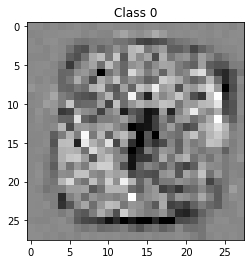

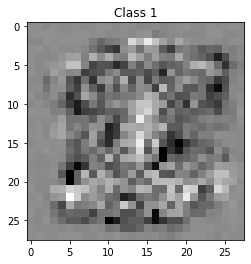

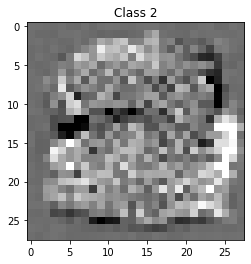

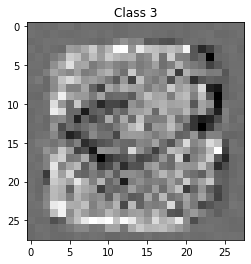

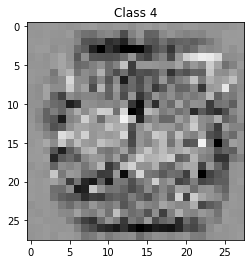

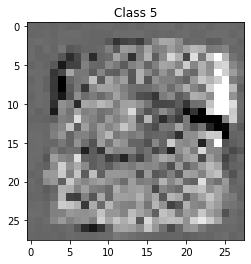

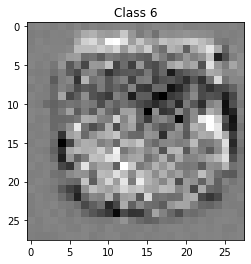

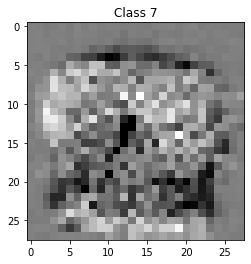

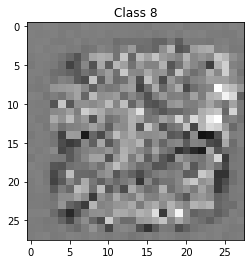

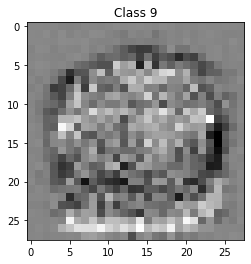

In [107]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp = temp / 2 + 0.5  # un-normalize
        temp_np = temp.numpy()
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [108]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(network.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
        
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [109]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.517943
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.366550
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.571013
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.506644
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.576970
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.441485
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.475280
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.607061
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.458690
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.500098

Test set: Average loss: 2.5285, Accuracy: 788/10000 (8%)



# **Answer (3):**
create needed blocks of code (and results) below

In [110]:
class MultiLayerNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return x

In [111]:
lr = 0.01

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)

    for i in range(1, epochs+1):
        train(i, mnist_train_loader)

    test(mnist_test_loader)
    
    lr *= 10

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.385432
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.248857
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.205431
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.093714
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.093532
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.166034
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.108182
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.095300
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.041175
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.138368
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.045581
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.039461
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.045197
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.057518
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.203914
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.050899
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.957380
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.085741
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.057173
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 1.084628
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.013687
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.925956
Train Epoch: 7 [44800/60000 (75%)]	Loss: 1.036691
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.123524
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.037828
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.938882
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.938989
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.983773
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.973607
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.958575
Train Epoch: 8 [32000/60000 (53%)]	Loss: 1.049054
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.903704
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.974624
Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.067081
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.980078
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.884133
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.953894
Train Epoch: 9 [12800/60000 (21%)]	Loss: 1.081290
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.994124
Train Epoch:

Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.488285
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.319511
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.212388
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.246139
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.426362
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.158551
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.175876
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.935326
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.141121
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.054923
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.209881
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.261068
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.109465
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.325731
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.339229
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.153895
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.282472
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.191811
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.136230
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.375488
Train Epoch:

# **Answer (4):**
create needed blocks of code (and results) below

In [112]:
dataset = 'cifar10'
lr = 0.01

In [113]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [114]:
# train and test functions
def temp_train(epoch, train_loader):
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [115]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.315243
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.285632
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.214455
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.954165
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.961550
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.943503
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.797591
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.830074
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.931199
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.942294
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.849416
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.788788
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.734164
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.835780
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.682027
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.668008
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.770953
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.771669
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.889042
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.679665
Train Epoch: 3 [25

[62.79841995239258,
 62.794769287109375,
 71.59203338623047,
 78.95471954345703,
 71.77944946289062,
 74.68412780761719,
 60.46809768676758,
 62.36297607421875,
 56.33200454711914,
 60.5112190246582,
 79.8987045288086,
 67.65996551513672,
 61.70844650268555,
 64.55897521972656,
 64.80408477783203,
 48.06187057495117,
 72.71781158447266,
 65.27726745605469,
 59.84436798095703,
 84.45018768310547,
 71.5643310546875,
 60.987327575683594,
 50.826873779296875,
 69.70677185058594,
 72.90213012695312,
 65.19446563720703,
 77.77804565429688,
 75.5455322265625,
 67.3409194946289,
 71.82149505615234,
 83.02225494384766,
 73.57647705078125,
 62.56471633911133,
 67.55337524414062,
 60.00815963745117,
 64.51821899414062,
 69.06900024414062,
 66.01891326904297,
 64.24129486083984,
 95.33843231201172,
 70.35746002197266,
 69.10779571533203,
 62.662139892578125,
 65.43096160888672,
 68.73528289794922,
 68.30183410644531,
 63.40188217163086,
 68.65200805664062,
 59.232093811035156,
 70.27361297607422,


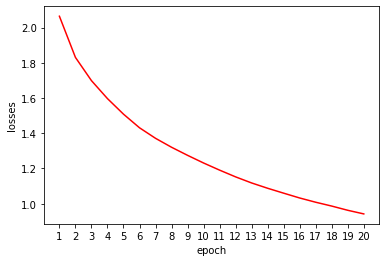

In [116]:
fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')

plt.show()